### SOLID: a Framework of Synergizing Optimization and Large Language Models for Intelligent Decision-Making
Authors: Yinsheng Wang, Tario You, Léonard Boussioux

In this model, we build two agents to decide an investment strategy for a portfolio of stocks.
For simplicity, we assume that the portfolio consists of 4 stocks: NVDA, GOOG, MSTR, and SMCI.
The first agent is a mean-variance optimization model. It aims to minimize the portfolio variance while achieving a target return.
The second agent is a GPT-based Language Model. Through prompt-based learning, it aims to generate a portfolio strategy that maximizes the portfolio return.
The two agents will communicate with each other to reach a consensus on the portfolio strategy, i.e., the portfolio weights for the two stocks.

#### Import necessary libraries

In [27]:
from openai import OpenAI
import json
import pandas as pd
from tqdm import tqdm
import yfinance as yf
import pandas_market_calendars as mcal
import datetime
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import expected_returns
from pypfopt import plotting
from pypfopt import risk_models
import numpy as np
import matplotlib.pyplot as plt
import json
from typing import List
from openai import OpenAI
import os
import re
import pandas as pd
from tqdm import tqdm
import yfinance as yf
from gurobipy import Model, GRB, quicksum
import warnings
from dotenv import load_dotenv
import matplotlib.colors as mcolors

load_dotenv()

warnings.filterwarnings('ignore')

pd.set_option('display.expand_frame_repr', False)  # Prevent splitting
pd.set_option('display.max_columns', None)        # Show all columns
pd.set_option('display.max_rows', None)           # Optional: Show all rows

api_key = os.getenv("PPLX")

# tickers = ["NVDA", "GOOG", "MSTR", "SMCI", "TSLA", "WMT"] # 1
# tickers = ["AAPL", "JPM", "XOM", "JNJ", "WMT", "HD", "AMT", "BA", "NEE"] # 2
# tickers = ["NVDA", "GOOG", "MSTR", "SMCI", "TSLA", "AAPL", "JPM", "XOM", "JNJ", "WMT", "HD", "AMT", "BA", "NEE"] # 3
# tickers = ["NVDA", "GOOG", "MSTR", "SMCI", "TSLA", "AAPL", "JPM", "XOM", "JNJ", "WMT", "HD", "AMT", "BA", "NEE", "V"] # 4
# tickers = ["AAPL", "MSFT", "NVDA", "GOOGL", "META", "JPM", "XOM", "UNH", "WMT", "HD", "CAT", "PLD", "NEE", "V", "AMD"] # 6% better
# tickers = ["MS", "BAC", "CVX", "PFE", "PEP", "COST", "NFLX", "INTC", "LMT", "CSCO", "AXP", "AMZN", "TMUS", "TM", "DUK"]
tickers = ["CVX", "PFE", "NFLX", "LMT", "TM", "PLTR", "OKTA", "MAR", "MCD", "SBUX", "EBAY", "MRNA", "BHP", "TGT", "EOG"]

In [28]:
# CHANGE THESE!!
appendage = "chev15" # "_15_original" # "_morgan15"
iteration = 5

# always just appends
init_news_path = f"assets/init_news_reports.json"
stock_data_path = f"assets/stock_data.json"

pft_path = f"assets/portfolio_{appendage}.csv"
stock_price_history_image_path = f'figures/stock_price_history_{appendage}.png'

grid_image_path = f'assets/output_{appendage}_{iteration}.png'
weights_coord_path = f"assets/weights_coord_{appendage}_{iteration}.json"
weights_llm_path = f"assets/weights_llm_{appendage}_{iteration}.json"
weights_opt_path = f"assets/weights_opt_{appendage}_{iteration}.json"
pft_value_over_time_path = f'figures/pft_value_over_time_{appendage}_{iteration}.png'
main_file_path = f"main_{appendage}_{iteration}.ipynb"

rerun_opt, rerun_llm, rerun_coord = True, True, True

#### Functions to save data locally

In [29]:
def save_data(data, file_path=stock_data_path):
    """
    Saves the dictionary 'data' to a JSON file at 'file_path'.
    """
    with open(file_path, 'w') as fp:
        json.dump(data, fp, indent=4)
    print(f"Data saved to {file_path}")

def load_data(file_path=stock_data_path):
    """
    Loads JSON data from 'file_path' and returns it as a dictionary.
    """
    with open(file_path, 'r') as fp:
        data = json.load(fp)
    print(f"Data loaded from {file_path}")
    return data

def patch_data(
    tickers,
    file_path=stock_data_path
):
    """
    Load existing data from file_path, then patch each month's dictionary
    to include 'MSTR' and 'SMCI' using Perplexity.ai's OpenAI-like client calls.
    Finally, save the patched data back to file_path.
    """

    # 1) Load the existing data
    data = load_data(file_path)

    # 2) Set up your client, months, system prompt, etc.
    client = OpenAI(api_key=api_key, base_url="https://api.perplexity.ai")

    months = [
        "January", "Febuary", "March", "April", "May", "June",
        "July", "August", "September", "October", "November", "December"
    ]
    
    system_prompt = {
        "role": "system",
        "content": (
            "Show me key news on [Company X] from [Date Range]. This list isn't exhaustive—earnings, leadership changes, regulatory updates, major headlines, M&A, industry trends, product launches, analyst opinions, investor activism, competitor moves—but only pick what's most representative for [Company X]'s stock performance. If other items seem more important, include them. Summarize in bullet points; avoid complete sentences; aim for maximum information. You don't have to include everything, just the key pieces. Keep final summary around 400 words."
        )
    }

    # 3) Patch each month's dictionary if tickers dont exist
    for i, monthly_data in enumerate(data):
        for j in tqdm(range(len(tickers))):
            ticker = tickers[j]
            if ticker not in monthly_data:
                # Build the request messages for the missing ticker
                messages = [
                    system_prompt,
                    {
                        "role": "user",
                        "content": f"What happened to {ticker} in {months[i]} 2024?"
                    }
                ]

                # Make the API call
                response = client.chat.completions.create(
                    model="llama-3.1-sonar-large-128k-online",
                    messages=messages,
                )

                # Save the result in the monthly dictionary
                monthly_data[ticker] = {"news": response.choices[0].message.content}
                print(f'patched: month {months[i]}\t{ticker}')
            else:
                print(f'skipping: {ticker}')
            
            save_data(data, file_path)

    # 4) Save the patched data back to the JSON file
    save_data(data, file_path)

#### Using Perplexity to gather news about the tickers

In [30]:
client = OpenAI(api_key=api_key, base_url="https://api.perplexity.ai")
months = ["January", "Febuary", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
data = [
    # Jan
    # {
    #     "MSFT":{
    #         "news": "yay", # news for all of Jan
    #         "price": 20 # last day's closing price - Jan 31
    #     }
    # }
]

#### Loading the S&P 500 tickers

In [31]:
file_path = 'assets/constituents.csv'
data = pd.read_csv(file_path)
constituents = data['Symbol'].tolist()

# constituents

#### Patching data for tickers

In [32]:
patch_data(tickers)
# S&P 500: patch_data(constituents)

Data loaded from assets/stock_data.json


100%|██████████| 15/15 [00:00<00:00, 104.67it/s]


skipping: CVX
Data saved to assets/stock_data.json
skipping: PFE
Data saved to assets/stock_data.json
skipping: NFLX
Data saved to assets/stock_data.json
skipping: LMT
Data saved to assets/stock_data.json
skipping: TM
Data saved to assets/stock_data.json
skipping: PLTR
Data saved to assets/stock_data.json
skipping: OKTA
Data saved to assets/stock_data.json
skipping: MAR
Data saved to assets/stock_data.json
skipping: MCD
Data saved to assets/stock_data.json
skipping: SBUX
Data saved to assets/stock_data.json
skipping: EBAY
Data saved to assets/stock_data.json
skipping: MRNA
Data saved to assets/stock_data.json
skipping: BHP
Data saved to assets/stock_data.json
skipping: TGT
Data saved to assets/stock_data.json
skipping: EOG
Data saved to assets/stock_data.json


  0%|          | 0/15 [00:00<?, ?it/s]

skipping: CVX
Data saved to assets/stock_data.json
skipping: PFE
Data saved to assets/stock_data.json
skipping: NFLX
Data saved to assets/stock_data.json
skipping: LMT
Data saved to assets/stock_data.json
skipping: TM


100%|██████████| 15/15 [00:00<00:00, 93.13it/s]


Data saved to assets/stock_data.json
skipping: PLTR
Data saved to assets/stock_data.json
skipping: OKTA
Data saved to assets/stock_data.json
skipping: MAR
Data saved to assets/stock_data.json
skipping: MCD
Data saved to assets/stock_data.json
skipping: SBUX
Data saved to assets/stock_data.json
skipping: EBAY
Data saved to assets/stock_data.json
skipping: MRNA
Data saved to assets/stock_data.json
skipping: BHP
Data saved to assets/stock_data.json
skipping: TGT
Data saved to assets/stock_data.json
skipping: EOG
Data saved to assets/stock_data.json


  0%|          | 0/15 [00:00<?, ?it/s]

skipping: CVX
Data saved to assets/stock_data.json
skipping: PFE
Data saved to assets/stock_data.json
skipping: NFLX
Data saved to assets/stock_data.json
skipping: LMT
Data saved to assets/stock_data.json
skipping: TM
Data saved to assets/stock_data.json
skipping: PLTR
Data saved to assets/stock_data.json
skipping: OKTA
Data saved to assets/stock_data.json
skipping: MAR
Data saved to assets/stock_data.json
skipping: MCD
Data saved to assets/stock_data.json
skipping: SBUX
Data saved to assets/stock_data.json
skipping: EBAY
Data saved to assets/stock_data.json
skipping: MRNA


100%|██████████| 15/15 [00:00<00:00, 108.38it/s]


Data saved to assets/stock_data.json
skipping: BHP
Data saved to assets/stock_data.json
skipping: TGT
Data saved to assets/stock_data.json
skipping: EOG
Data saved to assets/stock_data.json


  0%|          | 0/15 [00:00<?, ?it/s]

skipping: CVX
Data saved to assets/stock_data.json
skipping: PFE
Data saved to assets/stock_data.json
skipping: NFLX
Data saved to assets/stock_data.json
skipping: LMT
Data saved to assets/stock_data.json
skipping: TM
Data saved to assets/stock_data.json
skipping: PLTR
Data saved to assets/stock_data.json
skipping: OKTA


 60%|██████    | 9/15 [00:00<00:00, 89.63it/s]

Data saved to assets/stock_data.json
skipping: MAR
Data saved to assets/stock_data.json
skipping: MCD
Data saved to assets/stock_data.json
skipping: SBUX


100%|██████████| 15/15 [00:00<00:00, 100.67it/s]


Data saved to assets/stock_data.json
skipping: EBAY
Data saved to assets/stock_data.json
skipping: MRNA
Data saved to assets/stock_data.json
skipping: BHP
Data saved to assets/stock_data.json
skipping: TGT
Data saved to assets/stock_data.json
skipping: EOG
Data saved to assets/stock_data.json


  0%|          | 0/15 [00:00<?, ?it/s]

skipping: CVX
Data saved to assets/stock_data.json
skipping: PFE
Data saved to assets/stock_data.json
skipping: NFLX
Data saved to assets/stock_data.json
skipping: LMT
Data saved to assets/stock_data.json
skipping: TM


 73%|███████▎  | 11/15 [00:00<00:00, 101.96it/s]

Data saved to assets/stock_data.json
skipping: PLTR
Data saved to assets/stock_data.json
skipping: OKTA
Data saved to assets/stock_data.json
skipping: MAR
Data saved to assets/stock_data.json
skipping: MCD
Data saved to assets/stock_data.json
skipping: SBUX
Data saved to assets/stock_data.json
skipping: EBAY
Data saved to assets/stock_data.json
skipping: MRNA
Data saved to assets/stock_data.json
skipping: BHP
Data saved to assets/stock_data.json
skipping: TGT


100%|██████████| 15/15 [00:00<00:00, 104.39it/s]


Data saved to assets/stock_data.json
skipping: EOG
Data saved to assets/stock_data.json


  0%|          | 0/15 [00:00<?, ?it/s]

skipping: CVX
Data saved to assets/stock_data.json
skipping: PFE
Data saved to assets/stock_data.json
skipping: NFLX
Data saved to assets/stock_data.json
skipping: LMT
Data saved to assets/stock_data.json
skipping: TM
Data saved to assets/stock_data.json
skipping: PLTR
Data saved to assets/stock_data.json
skipping: OKTA
Data saved to assets/stock_data.json
skipping: MAR
Data saved to assets/stock_data.json
skipping: MCD
Data saved to assets/stock_data.json
skipping: SBUX


 80%|████████  | 12/15 [00:00<00:00, 112.55it/s]

Data saved to assets/stock_data.json
skipping: EBAY
Data saved to assets/stock_data.json
skipping: MRNA
Data saved to assets/stock_data.json
skipping: BHP


100%|██████████| 15/15 [00:00<00:00, 116.21it/s]


Data saved to assets/stock_data.json
skipping: TGT
Data saved to assets/stock_data.json
skipping: EOG
Data saved to assets/stock_data.json


  0%|          | 0/15 [00:00<?, ?it/s]

skipping: CVX
Data saved to assets/stock_data.json
skipping: PFE
Data saved to assets/stock_data.json
skipping: NFLX
Data saved to assets/stock_data.json
skipping: LMT
Data saved to assets/stock_data.json
skipping: TM
Data saved to assets/stock_data.json
skipping: PLTR
Data saved to assets/stock_data.json
skipping: OKTA
Data saved to assets/stock_data.json
skipping: MAR
Data saved to assets/stock_data.json
skipping: MCD
Data saved to assets/stock_data.json
skipping: SBUX
Data saved to assets/stock_data.json
skipping: EBAY
Data saved to assets/stock_data.json
skipping: MRNA
Data saved to assets/stock_data.json
skipping: BHP


100%|██████████| 15/15 [00:00<00:00, 142.68it/s]


Data saved to assets/stock_data.json
skipping: TGT
Data saved to assets/stock_data.json
skipping: EOG
Data saved to assets/stock_data.json


  0%|          | 0/15 [00:00<?, ?it/s]

skipping: CVX
Data saved to assets/stock_data.json
skipping: PFE
Data saved to assets/stock_data.json
skipping: NFLX
Data saved to assets/stock_data.json
skipping: LMT
Data saved to assets/stock_data.json
skipping: TM
Data saved to assets/stock_data.json
skipping: PLTR
Data saved to assets/stock_data.json
skipping: OKTA
Data saved to assets/stock_data.json
skipping: MAR
Data saved to assets/stock_data.json
skipping: MCD
Data saved to assets/stock_data.json
skipping: SBUX
Data saved to assets/stock_data.json
skipping: EBAY
Data saved to assets/stock_data.json
skipping: MRNA
Data saved to assets/stock_data.json
skipping: BHP
Data saved to assets/stock_data.json
skipping: TGT


100%|██████████| 15/15 [00:00<00:00, 139.56it/s]


Data saved to assets/stock_data.json
skipping: EOG
Data saved to assets/stock_data.json


  0%|          | 0/15 [00:00<?, ?it/s]

skipping: CVX
Data saved to assets/stock_data.json
skipping: PFE
Data saved to assets/stock_data.json
skipping: NFLX
Data saved to assets/stock_data.json
skipping: LMT
Data saved to assets/stock_data.json
skipping: TM
Data saved to assets/stock_data.json
skipping: PLTR
Data saved to assets/stock_data.json
skipping: OKTA
Data saved to assets/stock_data.json
skipping: MAR
Data saved to assets/stock_data.json
skipping: MCD
Data saved to assets/stock_data.json
skipping: SBUX
Data saved to assets/stock_data.json
skipping: EBAY
Data saved to assets/stock_data.json
skipping: MRNA
Data saved to assets/stock_data.json
skipping: BHP
Data saved to assets/stock_data.json
skipping: TGT


100%|██████████| 15/15 [00:00<00:00, 140.72it/s]


Data saved to assets/stock_data.json
skipping: EOG
Data saved to assets/stock_data.json


  0%|          | 0/15 [00:00<?, ?it/s]

skipping: CVX
Data saved to assets/stock_data.json
skipping: PFE
Data saved to assets/stock_data.json
skipping: NFLX
Data saved to assets/stock_data.json
skipping: LMT
Data saved to assets/stock_data.json
skipping: TM
Data saved to assets/stock_data.json
skipping: PLTR
Data saved to assets/stock_data.json
skipping: OKTA
Data saved to assets/stock_data.json
skipping: MAR
Data saved to assets/stock_data.json
skipping: MCD
Data saved to assets/stock_data.json
skipping: SBUX
Data saved to assets/stock_data.json
skipping: EBAY


 73%|███████▎  | 11/15 [00:00<00:00, 106.31it/s]

Data saved to assets/stock_data.json
skipping: MRNA
Data saved to assets/stock_data.json
skipping: BHP
Data saved to assets/stock_data.json
skipping: TGT
Data saved to assets/stock_data.json
skipping: EOG


100%|██████████| 15/15 [00:00<00:00, 94.78it/s] 


Data saved to assets/stock_data.json


  0%|          | 0/15 [00:00<?, ?it/s]

skipping: CVX
Data saved to assets/stock_data.json
skipping: PFE
Data saved to assets/stock_data.json
skipping: NFLX
Data saved to assets/stock_data.json
skipping: LMT
Data saved to assets/stock_data.json
skipping: TM
Data saved to assets/stock_data.json
skipping: PLTR
Data saved to assets/stock_data.json
skipping: OKTA
Data saved to assets/stock_data.json
skipping: MAR


 60%|██████    | 9/15 [00:00<00:00, 89.67it/s]

Data saved to assets/stock_data.json
skipping: MCD
Data saved to assets/stock_data.json
skipping: SBUX
Data saved to assets/stock_data.json
skipping: EBAY
Data saved to assets/stock_data.json
skipping: MRNA
Data saved to assets/stock_data.json
skipping: BHP
Data saved to assets/stock_data.json
skipping: TGT


100%|██████████| 15/15 [00:00<00:00, 104.18it/s]


Data saved to assets/stock_data.json
skipping: EOG
Data saved to assets/stock_data.json


  0%|          | 0/15 [00:00<?, ?it/s]

skipping: CVX
Data saved to assets/stock_data.json
skipping: PFE
Data saved to assets/stock_data.json
skipping: NFLX
Data saved to assets/stock_data.json
skipping: LMT
Data saved to assets/stock_data.json
skipping: TM
Data saved to assets/stock_data.json
skipping: PLTR
Data saved to assets/stock_data.json
skipping: OKTA
Data saved to assets/stock_data.json
skipping: MAR
Data saved to assets/stock_data.json
skipping: MCD
Data saved to assets/stock_data.json
skipping: SBUX


 67%|██████▋   | 10/15 [00:00<00:00, 71.87it/s]

Data saved to assets/stock_data.json
skipping: EBAY
Data saved to assets/stock_data.json
skipping: MRNA


100%|██████████| 15/15 [00:00<00:00, 83.94it/s]

Data saved to assets/stock_data.json
skipping: BHP
Data saved to assets/stock_data.json
skipping: TGT
Data saved to assets/stock_data.json
skipping: EOG
Data saved to assets/stock_data.json
Data saved to assets/stock_data.json


#### Initial stock introductions

In [33]:
def load_init_news_reports():
    with open("assets/init_news_reports.json", "r") as f:
        stock_reports = json.load(f)
    return stock_reports

def save_init_news_reports(init_news_reports):
    with open("assets/init_news_reports.json", "w") as f:
        json.dump(init_news_reports, f, indent=4)

def patch_init_news_reports():
    client = OpenAI(api_key=api_key, base_url="https://api.perplexity.ai")
    
    init_news_reports = load_init_news_reports()
    for ticker in tickers:
        if ticker not in init_news_reports:

            messages = [
                {
                    "role": "system",
                    "content": "You analyze and summarize companies."
                },
                {
                    "role": "user",
                    "content": f"Give me a 100 word summary about the stock ticker {ticker}"
                }
            ]

            response = client.chat.completions.create(
                model="llama-3.1-sonar-large-128k-online",
                messages=messages,
            ) 

            init_news_reports[ticker] = response.choices[0].message.content

    save_init_news_reports(init_news_reports)

patch_init_news_reports()

#### Get ticker prices

In [34]:
def get_last_trading_day_of_month(year, month, exchange='NYSE'):
    # Create a calendar for the specified exchange
    calendar = mcal.get_calendar(exchange)
    
    # Get the last day of the specified month
    if month == 12:
        last_day = datetime.datetime(year + 1, 1, 1) - datetime.timedelta(days=1)
    else:
        last_day = datetime.datetime(year, month + 1, 1) - datetime.timedelta(days=1)
    
    # Get the schedule for the month
    schedule = calendar.schedule(start_date=f"{year}-{month:02d}-01", end_date=last_day)
    
    # If the schedule is empty, there were no trading days this month
    if schedule.empty:
        return None
    
    # Return the last trading day
    return schedule.index[-1].date().day

def get_stock_price(tickers, date):
    prices = yf.download(tickers, start=date, end=date + datetime.timedelta(days=1))
    prices = prices["Adj Close"].dropna(how="all")
    prices = prices.values.tolist()
    return prices[0]

def get_closing_prices(data_loaded):
    year = 2024
    for month in range(1, 13):
        date = get_last_trading_day_of_month(year, month)
        datetime_obj = datetime.datetime(year, month, date)
        prices = get_stock_price(tickers, datetime_obj)

        for i, ticker in enumerate(tickers):
            data_loaded[month-1][ticker]['price'] = prices[i]

    save_data(data_loaded)

data_loaded = load_data()
get_closing_prices(data_loaded)

Data loaded from assets/stock_data.json


[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  15 of 15 completed

Data saved to assets/stock_data.json


#### Getting the tickers' historical prices for the optimizer
This is not just closing price at the end of each month like above, it's the entire data for a year

In [35]:
leo_key = os.getenv("CHAT")

client = OpenAI(
    api_key=leo_key,
)

def get_stock_price(tickers, start_date, end_date):
    prices = yf.download(tickers, start=start_date, end=end_date)
    prices = prices["Adj Close"].dropna(how="all")
    return prices

start_date = datetime.datetime(2024, 1, 1)
end_date = datetime.datetime.today().date()

portfolio = get_stock_price(tickers, start_date, end_date)
portfolio.to_csv(pft_path, index=True)
portfolio = pd.read_csv(pft_path, parse_dates=True, index_col="Date")

[*********************100%***********************]  15 of 15 completed


#### Historical ticker prices

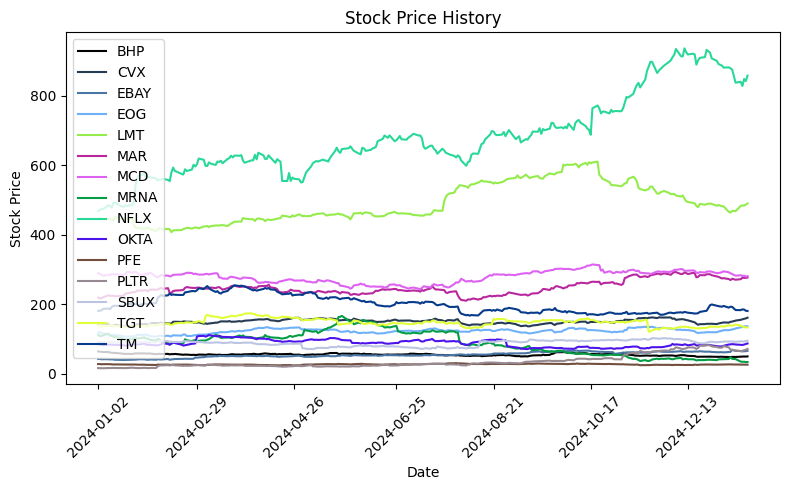

In [36]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

df = portfolio

# Function to generate a list of colors by iterating through RGB values
def generate_colors(n_colors):
    colors = []
    for i in range(n_colors):
        r = (i * 37) % 256 / 255.0  # Example formula for varying red
        g = (i * 59) % 256 / 255.0  # Example formula for varying green
        b = (i * 83) % 256 / 255.0  # Example formula for varying blue
        colors.append((r, g, b))
    return colors

# Generate unique colors based on the number of columns
colors = generate_colors(len(df.columns))

# Plot
plt.figure(figsize=(8, 5))

# Plot each column with a unique color
for idx, column in enumerate(df.columns):
    plt.plot(df.index, df[column], label=column, color=colors[idx])

# Formatting the x-axis
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Stock Price History")
plt.legend()

tick_indices = df.index[::40]  # Select every 60th index
plt.xticks(tick_indices, [date.strftime('%Y-%m-%d') for date in tick_indices], rotation=45)

plt.tight_layout()

# Save the plot
plt.savefig(stock_price_history_image_path, dpi=500, bbox_inches='tight')

# Show the plot
plt.show()


Expected annual return: 16.9%
Annual volatility: 14.1%
Sharpe Ratio: 1.06


BHP     0.134336
CVX     0.096037
EBAY    0.121361
EOG     0.093290
LMT     0.039893
MAR     0.141726
MCD     0.074643
MRNA    0.359344
NFLX    0.127286
OKTA    0.207556
PFE     0.112296
PLTR    0.411132
SBUX    0.159560
TGT     0.177309
TM      0.163426
Name: mkt, dtype: float64

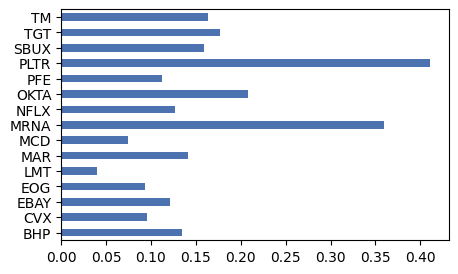

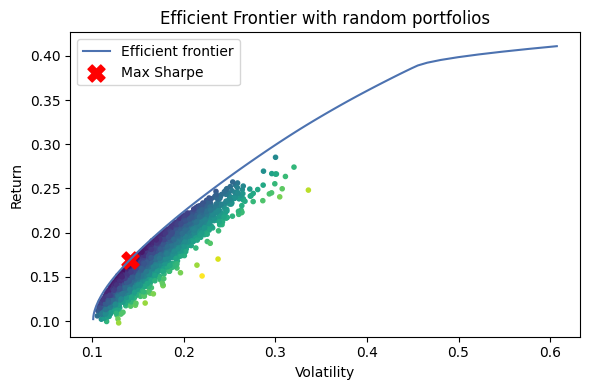

In [37]:
sample_cov = risk_models.sample_cov(portfolio, frequency=252)

S = risk_models.CovarianceShrinkage(portfolio).ledoit_wolf()
mu = expected_returns.capm_return(portfolio)

mu.plot.barh(figsize=(5, 3))

ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()

cleaned_weights = ef.clean_weights()
ef.portfolio_performance(verbose=True)


latest_prices = get_latest_prices(portfolio)

da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=100000)

# Number of shares of each stock to purchase
allocation, leftover = da.greedy_portfolio()

n_samples = 10000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu)
stds = np.sqrt((w.T * (S @ w.T)).sum(axis=0))
sharpes = rets / stds

ef = EfficientFrontier(mu, S)

fig, ax = plt.subplots(figsize=(6, 4))
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu, S)
ef2.max_sharpe()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()

# Plot random portfolios
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")
ax.scatter(std_tangent, ret_tangent, c='red', marker='X',s=150, label= 'Max Sharpe')

# Format
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()

mu

#### Generate initial stock info

In [38]:
with open(init_news_path, "r") as f:
    stock_reports = json.load(f)
stock_reports

{'NVDA': "NVIDIA is a leading American semiconductor company specializing in the design and manufacture of high-end graphics processing units (GPUs). Founded in 1993 and headquartered in Santa Clara, California, NVIDIA has become a dominant force in the GPU market, holding approximately 80% of the global market share as of 2023. The company's GPUs are widely used in gaming, professional visualization, data centers, and artificial intelligence applications. NVIDIA has positioned itself as a key player in the AI industry, with its GPUs powering many AI and machine learning platforms, including OpenAI's ChatGPT. The company's focus on innovation and rapid product development cycles has contributed to its strong market position and growth in recent years.",
 'GOOG': "Alphabet Inc. is the parent company of Google, created through a restructuring in 2015. As one of the world's largest technology companies, Alphabet is headquartered in Mountain View, California. The company's primary revenue 

In [39]:
# brief stock introductions obtained from Perplexity.ai
def generate_data_summary(reports):
    summary = f"Recent reports indicate:\n"
    for ticker in tickers:
        report = reports[ticker]
        summary += f"For {ticker}:\n{report}\n\n"
    return summary

initial_stock_info = generate_data_summary(stock_reports)

#### Dynamic YF stock data storage
pre download the data

In [40]:
# get the data
start_date = datetime.datetime(2023, 1, 1)
end_date = datetime.datetime(2025, 1, 1)
prices = yf.download(tickers, start=start_date, end=end_date)
portfolio = prices["Adj Close"].dropna(how="all")
portfolio.to_csv(pft_path, index=True)

[*********************100%***********************]  15 of 15 completed


In [41]:
# demonstration of the data being got
portfolio = pd.read_csv(pft_path, parse_dates=["Date"], index_col="Date")
start_date = datetime.datetime(2023, 12, 1)
end_date = datetime.datetime(2023, 12, get_last_trading_day_of_month(2023, 12))
df_subset = portfolio.loc[start_date:end_date]
df_subset

BHP         CVX       EBAY         EOG         LMT         MAR         MCD        MRNA        NFLX       OKTA        PFE       PLTR       SBUX         TGT          TM
Date                                                                                                                                                                                    
2023-12-01  59.699661  138.829086  40.935181  117.740883  437.944672  207.216660  279.194092   79.830002  465.739990  73.629997  27.244610  20.270000  96.678337  130.896698  192.740005
2023-12-04  58.201008  138.886597  40.827274  117.169334  439.191986  207.543411  279.360138   79.870003  453.899994  72.500000  27.593294  18.400000  95.118996  129.857559  187.369995
2023-12-05  57.878510  136.959641  40.689941  116.169106  434.855469  200.711441  279.760406   78.279999  455.149994  72.690002  27.414242  18.299999  93.111374  129.051468  187.990005
2023-12-06  58.286373  136.643250  40.680134  114.073395  437.944672  202.761017  280.072815   80.599998  446.730011  73.980003  27.131523  17.129999  94.553741  129.537048  189.889999
2023-12-07  59.462532  136.537796  40.689941  112.739754  435.703339  205.978973  280.004517   79.949997  452.000000  72.000000  26.980740  17.219999  93.988487  131.294891  190.240005
2023-12-08  59.244373  138.349731  40.503563  113.320839  436.590088  207.335464  278.774292   80.320000  453.760010  72.010002  27.122101  17.770000  94.154175  131.294891  187.279999
2023-12-11  58.874454  138.388107  40.964611  113.549454  439.747437  214.345673  282.308655   82.000000  459.890015  73.535004  26.990164  17.770000  95.625786  132.819656  187.080002
2023-12-12  58.950336  136.614502  40.326992  112.091995  440.108032  214.731812  284.524994   78.040001  463.000000  76.989998  26.933620  17.500000  95.655029  131.751358  184.800003
2023-12-13  60.752522  138.637360  41.160801  112.863594  439.922852  215.919998  288.928253   78.599998  479.980011  78.639999  25.124222  17.870001  95.616035  134.392990  185.479996
2023-12-14  62.156322  143.737625  41.837658  116.356209  433.910248  217.920090  283.158081   85.870003  469.829987  81.059998  24.624754  18.209999  95.352898  137.073456  183.419998
2023-12-15  62.402939  143.181595  40.954803  115.883453  430.538544  218.959717  280.473145   86.010002  472.059998  83.169998  25.095951  18.200001  94.290611  134.383255  180.619995
2023-12-18  62.687489  143.497940  41.710136  117.340317  435.508392  219.930069  283.363129   85.419998  486.119995  84.349998  25.501181  17.840000  94.105438  133.751999  183.279999
2023-12-19  63.749828  145.377014  42.838230  118.218300  436.365936  219.207260  283.851288   89.089996  495.019989  86.680000  26.537815  17.950001  95.235954  135.558395  183.949997
2023-12-20  62.630585  144.044403  42.161377  117.157013  431.308380  214.583282  282.152435   86.190002  489.269989  85.269997  26.038345  17.250000  92.302467  132.955627  179.940002
2023-12-21  64.299973  144.485428  42.897091  116.819328  436.590088  219.652817  284.495667   91.160004  491.609985  89.040001  26.679173  17.590000  92.906708  135.354446  180.860001
2023-12-22  64.328430  144.811371  42.985378  117.967453  436.785034  220.425125  284.798340   94.889999  486.760010  89.360001  26.763988  17.410000  92.857979  136.160538  178.529999
2023-12-26  64.707832  146.115189  42.651848  119.926018  438.694977  221.246948  285.930847   97.330002  491.190002  91.720001  26.773413  17.680000  93.238068  136.966614  179.850006
2023-12-27  65.343338  145.635864  42.553753  119.897064  437.515839  222.227203  287.580872  100.730003  491.790009  90.599998  26.961893  17.469999  92.867729  138.277756  180.720001
2023-12-28  65.087242  143.584244  42.642040  117.060532  439.718170  221.870758  288.840363   98.790001  490.510010  91.330002  27.131523  17.559999  93.491463  138.433121  181.110001
2023-12-29  64.793198  142.999420  42.789185  116.693886  441.676910  223.286621  289.494537   99.449997  486.880005  90.529999  27.1

#### Main class to integrate the LLM with the Portfolio Optimization model

In [42]:
class CoordinationFramework():
    def __init__(self, mu, Q, target_return, penalty=1, iteration=2, verbose=False):
        """
        Initialization of the class for coordination framework
        :param np.array mu: expected return of the stocks
        :param np.array Q: covariance matrix of the stocks
        :param float target_return: target return of the portfolio
        :param float penalty: penalty term in coordination algorithm
        :param float iteration: number of iteration of coordination algorithm
        """
        # Store the init params so we can restore them later
        self._init_mu = mu
        self._init_Q = Q
        self._init_target_return = target_return
        self._init_penalty = penalty
        self._init_iteration = iteration
        self._init_verbose = verbose

        # Now do the usual initialization
        self.mu = mu  # expected return
        self.Q = Q.to_numpy()  # covariance matrix
        self.n = len(mu)  # number of stocks
        self.target_return = target_return

        self.penalty = penalty
        self.iteration = iteration
        self.verbose = verbose

        # initialization
        self.current_plan = [0.0] * self.n
        self.optimization_plan = [0.0] * self.n
        self.LLM_plan = [0.0] * self.n
        self.optimization_price = [0.0] * self.n
        self.LLM_price = [0.0] * self.n

        self.feedback_factor = 0.1

        self.plan_histories = []
        self.conversation_history = []
        self.conversation_summaries = []

    def reset_variables(self):
        """
        Reset all variables to their initial values, exactly as they were in __init__.
        """
        # Restore parameters
        self.mu = self._init_mu
        self.Q = self._init_Q.to_numpy()  
        self.n = len(self._init_mu)
        self.target_return = self._init_target_return

        self.penalty = self._init_penalty
        self.iteration = self._init_iteration
        self.verbose = self._init_verbose

        # Reinitialize mutable state variables
        self.current_plan = [0.0] * self.n
        self.optimization_plan = [0.0] * self.n
        self.LLM_plan = [0.0] * self.n
        self.optimization_price = [0.0] * self.n
        self.LLM_price = [0.0] * self.n

        self.feedback_factor = 0.1

        self.plan_histories = []
        self.conversation_history = []
        self.conversation_summaries = []

    # In this function, the optimization model will update their preferred portfolio weights.
    def PortfolioOptimization_Agent(self, current_plan, verbose=False):
        # previous opt
        self.model = Model("mean_variance_optimization")
        self.model.setParam('OutputFlag', 0)
        # Add variables
        x = {}
        for i in range(self.n):
            x[i] = self.model.addVar(
                vtype=GRB.CONTINUOUS, name="x_{}".format(i))

        # Set objective
        obj = quicksum(self.Q[i, j] * x[i] * x[j]
                       for i in range(self.n) for j in range(self.n))
        dual = quicksum(
            self.optimization_price[i] * x[i] for i in range(self.n))
        penalty = self.penalty * \
            quicksum((x[i] - current_plan[i]) * (x[i] - current_plan[i])
                     for i in range(self.n))
        self.model.setObjective(obj + dual + penalty, GRB.MINIMIZE)

        # Add constraints
        self.model.addConstr(quicksum(x[i] for i in range(
            self.n)) == 1, "budget")  # budget constraint
        self.model.addConstr(quicksum(self.mu[i] * x[i] for i in range(
            self.n)) >= self.target_return, "target_return")  # target return constraint
        self.model.optimize()

        if verbose:
            print("\n[DEBUG] Building model with:")
            print(f"[DEBUG]   mu: {self.mu}")
            print(f"[DEBUG]   Q: {self.Q}")
            print(f"[DEBUG]   target_return: {self.target_return}")
            print("[DEBUG]   current_plan:", current_plan)
            print("[DEBUG]   optimization_price:", self.optimization_price)
            print("[DEBUG]   penalty:", self.penalty)
            print("[DEBUG]   x:", x)
            print("[DEBUG]   n:", self.n)
            
            self.model.write("debug/debug_model.lp")

            status = self.model.status
            print(f"[DEBUG] Gurobi optimization status: {status}")


        # Get results for portfolio weight on first stock
        weights = [x[i].x for i in range(self.n)]

        return weights

    def response_format(self):
        prompt = "please write your final recommendation in a single line, in the format below:\n\n"

        # Construct the label format dynamically based on the number of tickers.
        # Example of final output:  "AAPL: X1, MSFT: X2, AMZN: X3. Replace X1, X2, X3..."
        prompt += ", ".join([f"{ticker}: X{i+1}" for i, ticker in enumerate(tickers)])
        prompt += (
            ".\n\nReplace "
        )

        # Remind the model to replace placeholders with the actual confidence levels.
        prompt += ", ".join([f"X{i+1}" for i in range(len(tickers))])
        prompt += (
            " with the confidence level for each stock."
        )

        return prompt

    # In this function, the language model take the prompt as input and generate the preferred portfolio weights.
    def LLM_Agent(self, month_data, consensus_plan, month, iter, verbose=False):
        messages = [
            {"role": "system", "content": "You're a trader planning the next move of investment decisions. You always maximize the profit through your stock investments."},
        ]
        messages.extend(self.conversation_history)

        # ------------------------------------------------------------------------------
        # ------------------------------------------------------------------------------
        current_prompt = ""

        if iter == 0:
            # Optionally include any initial stock info if this is the very first iteration.
            current_prompt += (
                f"{initial_stock_info}\n\n"
            )

        # if month != 0 and len(self.conversation_summaries) != 0:
        #     current_prompt += "Here is what happened in the last few months for you to gain a background understanding of what happened:\n"
        #     current_prompt += "\n".join(self.conversation_summaries)
        #     current_prompt += "\n\n"

        stock_prices = f"The stock prices today are:\n"
        for i, ticker in enumerate(tickers):
            ticker_close = month_data[ticker]['price']
            stock_prices += f"{ticker} = {ticker_close}"
            if i != len(tickers) - 1:
                stock_prices += ", "
        stock_prices += "\n"

        stock_news = ""
        for ticker in tickers:
            ticker_news = month_data[ticker]['news']
            stock_news += f"news for {ticker}:\n{ticker_news}\n\n"

        if iter == 0:
            # If this is the first iteration in a given month, include relevant news and price info.
            current_prompt += (
                "Please read the following information carefully.\n\n"
                f"---\n**Stock News**\n\n{stock_news}\n\n"
                f"---\n**Recent Stock Prices**\n\n{stock_prices}\n\n"
            )

        # Begin the main decision instructions.
        current_prompt += (
            "You are a trader responsible for making portfolio allocation decisions. "
            "Use all relevant information provided (such as any past decisions, news, or stock data) to "
            "decide how much to invest in each stock.\n\n"
            "Think about:\n"
            "1. Any news articles and how they might affect each stock.\n"
            "2. Any patterns in recent price movements.\n"
            "3. Previous decisions you have made regarding portfolio weights.\n"
        )

        # If we're past the first iteration, include guidance about consensus plans.
        if iter != 0 and self.optimization_plan != [0.0] * self.n:
            current_prompt += (
                "Also, here is the **current optimizer plan**:\n"
                f"{self.optimization_plan}\n\n"
                "Decide whether you agree with the optimizer's plan. If you do, make any necessary adjustments to "
                "move your portfolio allocation closer to it.\n\n"
            )

        # Ask the model for a recommendation. Emphasize the requirement to explain reasoning first, then provide the format.
        current_prompt += (
            "### Task\n"
            "1. **Explain your decision process**. Discuss your reasoning and any trade-offs you considered.\n"
            "2. **Provide a recommended investment decision** for each stock in terms of confidence, choosing from "
            "one of the following 7 levels:\n"
            "   - Very Low Confidence\n"
            "   - Low Confidence\n"
            "   - Somewhat Low Confidence\n"
            "   - Neutral\n"
            "   - Somewhat High Confidence\n"
            "   - High Confidence\n"
            "   - Very High Confidence\n\n"
            "Even if you are unsure, you **must** provide the best decision you can based on the available information.\n\n"
            "### Response Format\n"
            "After your explanation, " + self.response_format()
        )

        
        # ------------------------------------------------------------------------------
        # ------------------------------------------------------------------------------


        if verbose:
            print(f"\n# month {month} iter {iter} prompt: \n{current_prompt}\n")

        messages.append({"role": "user", "content": current_prompt})

        result_dict = []
        retry_messages = [m for m in messages]
        attempt = 0
        retry = True
        retry_reason = ""
        while retry:
            if attempt != 0:
                if retry_reason == "INVALID FORMAT":
                    new_message = "Sorry, I could not parse your response. Please try again with the correct specified formatting: " + self.response_format()
                elif retry_reason == "ZERO SUM":
                    new_message = "The sum of the weights for each stock cannot be 0. Please try again: " + self.response_format()
                else: # "MISSING TICKER"
                    new_message = "You must include a confidence level for each ticker. Please try again: " + self.response_format()

                retry_messages.append({
                    "role": "user", 
                    "content": new_message
                })

                if verbose:
                    print(f"\n# month {month} iter {iter} RETRY PROMPT: \n{new_message}\n")

            attempt += 1
            # Make an API call to ChatGPT with the prompt
            response = client.chat.completions.create(
                model="gpt-4o-mini",
                messages=retry_messages,
                temperature=0
            )

            # Parse the decision from the response
            text = response.choices[0].message.content
            retry_messages.append({
                "role": "assistant",
                "content": text
            })

            if verbose:
                print(f"[DEBUG]\tChat reponse: {text}")

            CONFIDENCE_LEVELS = {
                "Very High": 0.6,
                "High": 0.5,
                "Somewhat High": 0.4,
                "Neutral": 0.3,
                "Somewhat Low": 0.2,
                "Low": 0.1,
                "Very Low": 0.0
            }

            # Create regex pattern from confidence levels
            pattern = "|".join(CONFIDENCE_LEVELS.keys())

            result_dict = {}
            for stock in tickers:
                # Use word boundary \b to ensure exact stock matches
                match = re.search(
                    fr'\b{stock}\b:\s*({pattern})',
                    text,
                    re.IGNORECASE
                )

                if match:
                    confidence = match.group(1).title()
                    result_dict[stock] = CONFIDENCE_LEVELS[confidence]
                else:
                    retry = True
                    if verbose:
                        print("[DEBUG]\tInvalid format, retrying.")
                        print(f"[DEBUG]\tfetched weights: {result_dict}")
                    continue

            retry = False

            if result_dict == {}:
                if verbose:
                    print("[DEBUG]\tInvalid format: could not find tickers, retrying.")
                retry = True
                retry_reason = "INVALID FORMAT"
                continue

            if sum(result_dict.values()) == 0:
                if verbose: 
                    print("[DEBUG]\tInvalid output: sum = 0")
                retry = True
                retry_reason = "ZERO SUM"
                continue

            if list(result_dict.keys()) != tickers:
                print(f"{list(result_dict.keys()) = }")
                if verbose: 
                    print("[DEBUG]\tInvalid output: not every ticker was outputted")
                retry = True
                retry_reason = "MISSING TICKER"
                continue

            if verbose:
                print(f"[DEBUG]\tfetched weights: {result_dict = }")
                retry = False
            

        # normalize sum to 1
        norm_factor = 1/sum(result_dict.values())
        result_dict = {k: v * norm_factor for k, v in result_dict.items()}
        result_dict = [r for r in result_dict.values()]


        self.conversation_history.append(
            {"role": "user", "content": current_prompt})
        self.conversation_history.append(
            {"role": "assistant", "content": text})

        norm_factor = 1/sum(result_dict)
        normalized_weights = [norm_factor * w for w in result_dict]

        return normalized_weights

    # update the consensus plan and activity price for the next iteration
    def update_plan(self, plan1, price1, plan2, price2):
        result = []
        # plan1 = [p for p in plan1.values()] # if using dict with tickers
        # plan2 = [p for p in plan2.values()]

        for p1, p2, pr1, pr2 in zip(plan1, plan2, price1, price2):
            average_plan = (p1 + p2) / 2
            average_price = (pr1 + pr2) / 2
            result.append(max(0, average_price / self.penalty + average_plan))
        return result

    def update_activity_price(self, current_activity_price, current_plan, new_plan):
        updated_prices = []

        for curr_price, curr_plan, new_plan_val in zip(current_activity_price, current_plan, new_plan):
            adjustment = self.penalty * (new_plan_val - curr_plan)
            updated_price = curr_price - adjustment
            updated_prices.append(updated_price)

        return updated_prices

    def test_convergence(self, all_llm_opt_plans):
        # if llm's plan and opt's plan do not differ by more than 5%
        try:
            plan_convergence = True
            for l in range(len(tickers)):
                if abs(all_llm_opt_plans[-1][l+len(tickers)+1] - all_llm_opt_plans[-1][l+2*len(tickers)+1]) > 1/20:
                    plan_convergence = False
                    break
            if plan_convergence:
                return True
        except Exception as e:
            print(f"Error occurred: {str(e)}")
        
        # if this iter's plan and last iter's plan do not differ by more than 2%
        # - weights have basically not changed in the past two iterations
        try:
            iter_convergence = True
            for i in range(1, len(all_llm_opt_plans[0])): 
                if abs(all_llm_opt_plans[-1][i] - all_llm_opt_plans[-2][i]) > 1/500:
                    iter_convergence = False
                    break
            if iter_convergence:
                return True
        except Exception as e:
            print(f"Error occurred: {str(e)}")

        return False
        
    def test_convergence_aux(self):
        max_diff = 0
        max_diff_ticker = None

        try:
            for l, ticker in enumerate(tickers):
                diff = abs(self.plan_histories[-1][l+len(tickers)+1] - self.plan_histories[-1][l+2*len(tickers)+1])
                if diff > max_diff:
                    max_diff = diff
                    max_diff_ticker = self.plan_histories[-1][0]

            print(f"[DEBUG]\tThe max diff ticker is {max_diff_ticker} with a diff of {max_diff}")
        except Exception as e:
            print(f"Error occurred: {str(e)}")


        
    def OptAlgorithm(self, data, verbose=False):
        self.reset_variables()

        for month, month_data in enumerate(data):
            prev_year = 2024 if month != 0 else 2023 
            prev_month = month if month != 0 else 12 
            
            start_date = datetime.datetime(prev_year, prev_month, 1)
            end_date = datetime.datetime(prev_year, prev_month, get_last_trading_day_of_month(prev_year, prev_month))

            portfolio = pd.read_csv(pft_path, parse_dates=["Date"], index_col="Date")
            portfolio = portfolio.loc[start_date:end_date]

            self.mu = expected_returns.mean_historical_return(portfolio) # capm_return / mean_historical_return
            self.Q = risk_models.CovarianceShrinkage(portfolio).ledoit_wolf().to_numpy()

            self.optimization_plan = self.PortfolioOptimization_Agent(self.current_plan)

            self.current_plan = self.optimization_plan
            self.optimization_price = self.update_activity_price(
                    self.optimization_price, self.optimization_plan, self.current_plan)
            
            self.plan_histories.append(self.optimization_plan)

        return self.plan_histories
    
    def LLMAlgorithm(self, data, verbose=False):
        self.reset_variables()

        for month, month_data in enumerate(data):
            self.LLM_plan = self.LLM_Agent(month_data, self.current_plan, month, 0, verbose=verbose)
            
            self.current_plan = self.LLM_plan
            self.LLM_Price = self.update_plan(
                    self.optimization_plan, self.optimization_price, self.LLM_plan, self.LLM_price)
            
            self.plan_histories.append(self.LLM_plan)

        return self.plan_histories
    
    def summarize(self):
        messages = [
            {"role": "system", "content": "You're a trader planning the next move of investment decisions. You always maximize the profit through your stock investments."},
        ]
        messages.extend(self.conversation_history)
        messages.append({
            "role": "user",
            "content": "Please summarize everything that happened in this conversation very succinctly, extracting the key pieces of information relevant to future stock assessments, as it will be used for another intelligent agent to overview what happened this month."
        })

        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=messages,
            temperature=0
        )
        text = response.choices[0].message.content
        self.conversation_summaries.append(text)

    # In this function, the coordination algorithm will update the preferred portfolio weights of the two agents.
    def CoordinationAlgorithm(self, data, verbose=False):
        self.reset_variables()
        
        for month, month_data in enumerate(data):

            prev_year = 2024 if month != 0 else 2023 
            prev_month = month if month != 0 else 12 
            
            start_date = datetime.datetime(prev_year, prev_month, 1)
            end_date = datetime.datetime(prev_year, prev_month, get_last_trading_day_of_month(prev_year, prev_month))

            portfolio = pd.read_csv(pft_path, parse_dates=["Date"], index_col="Date")
            portfolio = portfolio.loc[start_date:end_date]

            self.mu = expected_returns.mean_historical_return(portfolio) # capm_return / mean_historical_return
            self.Q = risk_models.CovarianceShrinkage(portfolio).ledoit_wolf().to_numpy()

            self.summarize()

            self.conversation_history = []

            for i in range(self.iteration):
                # optimization agent get the preferred portfolio weights
                
                self.optimization_plan = self.PortfolioOptimization_Agent(self.current_plan)
                # LLM agent get the preferred portfolio weights
                self.LLM_plan = self.LLM_Agent(month_data, self.current_plan, month, i, verbose=verbose)

                # update the plan for the next iteration
                self.current_plan = self.update_plan(
                    self.optimization_plan, self.optimization_price, self.LLM_plan, self.LLM_price)

                # Coordinator update dual variable/prices
                self.optimization_price = self.update_activity_price(
                    self.optimization_price, self.optimization_plan, self.current_plan)
                self.LLM_price = self.update_activity_price(
                    self.LLM_price, self.LLM_plan, self.current_plan)

                self.penalty = 1 - i/self.iteration

                all_llm_opt = [f"month {month} iter {i}"] + self.current_plan + \
                    self.LLM_plan + self.optimization_plan

                self.plan_histories.append(all_llm_opt)

                columns = ['status']
                categories = ['all', 'llm', 'opt']
                for c in categories:
                    for ticker in tickers:
                        columns.append(f'{c} {ticker}')

                if self.test_convergence(self.plan_histories):

                    all_llm_opt = [f"CONVERGED month {month} iter {i}"] + self.current_plan + \
                        self.LLM_plan + self.optimization_plan
                    self.plan_histories[-1] = all_llm_opt
                    df = pd.DataFrame(self.plan_histories, columns=columns)
                    if verbose:
                        print("[DEBUG]\tConverged because {} < ")
                        print(df)
                    break

                else: 
                    # get the largest gap 
                    self.test_convergence_aux()

                df = pd.DataFrame(self.plan_histories, columns=columns)
                if verbose:
                    print("## updated weights\n```")
                    print(df)
                    print("\n```\n")

        return self.plan_histories

In [43]:
CoordFW = CoordinationFramework(
    mu, S, 0.449055, penalty=1, iteration=20, verbose=False)
# appl15 0.93703
# morgan15 0.449055

#### Run the optimizer only, as baseline

In [44]:
if rerun_opt:
    opt_histories = CoordFW.OptAlgorithm(data_loaded)
    with open(weights_opt_path, "w") as f:
        json.dump(opt_histories, f, indent=4)

# -- OR --

with open(weights_opt_path, "r") as f:
    opt_histories = json.load(f)

opt_histories

[[0.06457580160134674,
  0.06915546916532636,
  0.06599989026567221,
  0.06948482779806209,
  0.07427591026410386,
  0.06762012277383592,
  0.07580213901574917,
  0.049706696397712066,
  0.06844396931235572,
  0.06282582354229259,
  0.07387712048704062,
  0.05406250893855981,
  0.06732122437832332,
  0.06656403089698448,
  0.07028446516263562],
 [0.06528683477835992,
  0.06929282783384043,
  0.06556045490112591,
  0.0704013043813633,
  0.07971676374221945,
  0.06793784487095803,
  0.07908475084639215,
  0.04179753263843039,
  0.064500330543051,
  0.059611576282622265,
  0.07752665916023868,
  0.04693886085945312,
  0.07018257805403257,
  0.06999815005365904,
  0.0721635310542291],
 [0.0674373757880171,
  0.07621637060812089,
  0.06591546195836573,
  0.07224887543172615,
  0.08539384471088374,
  0.0695396030371476,
  0.08364482186955555,
  0.033719956561920214,
  0.07020087280936117,
  0.054335168627745546,
  0.07944595132004416,
  0.019728233590028444,
  0.07423509681237937,
  0.073726

#### Run the LLM only, as baseline

In [45]:
if rerun_llm:
    llm_histories = CoordFW.LLMAlgorithm(data_loaded, True)
    with open(weights_llm_path, "w") as f:
        json.dump(llm_histories, f, indent=4)
    
# -- OR --

with open(weights_llm_path, "r") as f:
    llm_histories = json.load(f)

llm_histories


# month 0 iter 0 prompt: 
Recent reports indicate:
For CVX:
Chevron Corporation, traded under the ticker symbol CVX, is a multinational energy corporation engaged in integrated energy and chemicals operations globally. Listed on the New York Stock Exchange (NYSE), Chevron operates through two main segments: Upstream (exploration, production, and transportation of oil and gas) and Downstream (refining, marketing, and transportation of petroleum products)[2][4].

As of January 2025, CVX has a market capitalization of approximately $281.87 billion, with a P/E ratio of 17.24 and a dividend yield of 4.16%. Analysts have a "Moderate Buy" consensus rating, with a 12-month price target of $174.87. The company has recently reported earnings per share (EPS) of $9.10 and net income of $21.37 billion[2][4][5].

For PFE:
Pfizer Inc., traded as PFE on the NYSE, is one of the world's largest pharmaceutical companies, with annual sales nearing $50 billion, excluding COVID-19 product sales. The compan

[[0.09523809523809526,
  0.04761904761904763,
  0.11904761904761907,
  0.09523809523809526,
  0.09523809523809526,
  0.07142857142857144,
  0.04761904761904763,
  0.07142857142857144,
  0.023809523809523815,
  0.04761904761904763,
  0.07142857142857144,
  0.023809523809523815,
  0.023809523809523815,
  0.07142857142857144,
  0.09523809523809526],
 [0.08888888888888889,
  0.044444444444444446,
  0.1111111111111111,
  0.06666666666666667,
  0.08888888888888889,
  0.08888888888888889,
  0.08888888888888889,
  0.06666666666666667,
  0.044444444444444446,
  0.044444444444444446,
  0.06666666666666667,
  0.022222222222222223,
  0.022222222222222223,
  0.08888888888888889,
  0.06666666666666667],
 [0.09756097560975611,
  0.02439024390243903,
  0.12195121951219513,
  0.07317073170731707,
  0.09756097560975611,
  0.04878048780487806,
  0.09756097560975611,
  0.07317073170731707,
  0.02439024390243903,
  0.04878048780487806,
  0.07317073170731707,
  0.02439024390243903,
  0.02439024390243903,
  

#### Run the coordinator algorithm

In [46]:
if rerun_coord:
    coord_histories = CoordFW.CoordinationAlgorithm(data_loaded, True)
    with open(weights_coord_path, "w") as f:
        json.dump(coord_histories, f, indent=4)

# -- OR --

with open(weights_coord_path, "r") as f:
    coord_histories = json.load(f)

weights_coord = [h[1:1+len(tickers)] for h in coord_histories]

weights_coord


# month 0 iter 0 prompt: 
Recent reports indicate:
For CVX:
Chevron Corporation, traded under the ticker symbol CVX, is a multinational energy corporation engaged in integrated energy and chemicals operations globally. Listed on the New York Stock Exchange (NYSE), Chevron operates through two main segments: Upstream (exploration, production, and transportation of oil and gas) and Downstream (refining, marketing, and transportation of petroleum products)[2][4].

As of January 2025, CVX has a market capitalization of approximately $281.87 billion, with a P/E ratio of 17.24 and a dividend yield of 4.16%. Analysts have a "Moderate Buy" consensus rating, with a 12-month price target of $174.87. The company has recently reported earnings per share (EPS) of $9.10 and net income of $21.37 billion[2][4][5].

For PFE:
Pfizer Inc., traded as PFE on the NYSE, is one of the world's largest pharmaceutical companies, with annual sales nearing $50 billion, excluding COVID-19 product sales. The compan

[[0.07774244625521884,
  0.057305007309935915,
  0.08981812695101793,
  0.08019695935357651,
  0.07122886422296103,
  0.07926460684146341,
  0.06062834223514732,
  0.05894425728976513,
  0.056949257383450594,
  0.05414018449841902,
  0.07102946933442941,
  0.03839489083291627,
  0.056387884916434386,
  0.06737292453940133,
  0.08059677803586326],
 [0.0804842135097775,
  0.04499103330755437,
  0.09782684228962552,
  0.0714811665324081,
  0.07615637445163878,
  0.1002355561401983,
  0.06691378639197608,
  0.05619319126686243,
  0.07280830715784228,
  0.06214639012646715,
  0.06529499493633459,
  0.022281311765993822,
  0.04628863116444687,
  0.073953311214986,
  0.06294488974388215],
 [0.08049574135276107,
  0.03293082153466452,
  0.09873901503537824,
  0.08379322323531736,
  0.06928544762191419,
  0.07310793767208465,
  0.07353000723683732,
  0.05296614455909368,
  0.07906579528194235,
  0.04842160259802257,
  0.04166781828651265,
  0.03846154733874034,
  0.07101149468542427,
  0.077525

#### Display results

In [47]:
columns = ['status']
categories = ['all', 'llm', 'opt']
for c in categories:
    for ticker in tickers:
        columns.append(f'{c} {ticker}')

df = pd.DataFrame(coord_histories, columns=columns)
df

status   all CVX   all PFE  all NFLX   all LMT    all TM  all PLTR  all OKTA   all MAR   all MCD  all SBUX      all EBAY      all MRNA   all BHP       all TGT   all EOG   llm CVX   llm PFE  llm NFLX   llm LMT    llm TM  llm PLTR  llm OKTA   llm MAR   llm MCD  llm SBUX  llm EBAY  llm MRNA   llm BHP   llm TGT   llm EOG       opt CVX       opt PFE  opt NFLX       opt LMT        opt TM      opt PLTR      opt OKTA       opt MAR       opt MCD      opt SBUX      opt EBAY      opt MRNA       opt BHP       opt TGT       opt EOG
0     CONVERGED month 0 iter 0  0.077742  0.057305  0.089818  0.080197  0.071229  0.079265  0.060628  0.058944  0.056949  0.054140  7.102947e-02  3.839489e-02  0.056388  6.737292e-02  0.080597  0.090909  0.045455  0.113636  0.090909  0.068182  0.090909  0.045455  0.068182  0.045455  0.045455  0.068182  0.022727  0.045455  0.068182  0.090909  6.457580e-02  6.915547e-02  0.066000  6.948483e-02  7.427591e-02  6.762012e-02  7.580214e-02  4.970670e-02  6.844397e-02  6.282582e-02  7.387712e-02  5.406251e-02  6.732122e-02  6.656403e-02  7.028447e-02
1     CONVERGED month 1 iter 0  0.080484  0.044991  0.097827  0.071481  0.076156  0.100236  0.066914  0.056193  0.072808  0.062146  6.529499e-02  2.228131e-02  0.046289  7.395331e-02  0.062945  0.076923  0.038462  0.096154  0.057692  0.076923  0.115385  0.076923  0.057692  0.096154  0.076923  0.057692  0.019231  0.038462  0.076923  0.038462  8.404535e-02  5.152053e-02  0.099500  8.527003e-02  7.538967e-02  8.508650e-02  5.690450e-02  5.469407e-02  4.946277e-02  4.736970e-02  7.289768e-02  2.533185e-02  5.411572e-02  7.098355e-02  8.742824e-02
2               month 2 iter 0  0.080496  0.032931  0.098739  0.083793  0.069285  0.073108  0.073530  0.052966  0.079066  0.048422  4.166782e-02  3.846155e-02  0.071011  7.752566e-02  0.078998  0.076923  0.019231  0.096154  0.096154  0.057692  0.038462  0.076923  0.057692  0.076923  0.038462  0.019231  0.076923  0.096154  0.076923  0.096154  8.406841e-02  4.663087e-02  0.101324  7.143260e-02  8.087859e-02  1.077543e-01  7.013694e-02  4.823998e-02  8.120851e-02  5.838167e-02  6.410487e-02  1.775440e-08  4.586914e-02  7.812824e-02  6.184164e-02
3               month 2 iter 1  0.080089  0.025405  0.099119  0.091997  0.064233  0.054621  0.077794  0.052362  0.082011  0.041714  2.674674e-02  4.813278e-02  0.087296  7.946034e-02  0.089019  0.076923  0.019231  0.096154  0.096154  0.057692  0.038462  0.076923  0.057692  0.076923  0.038462  0.019231  0.076923  0.096154  0.076923  0.096154  8.325521e-02  3.157962e-02  0.102083  8.783942e-02  7.077465e-02  7.078000e-02  7.866496e-02  4.703125e-02  8.709887e-02  4.496671e-02  3.426270e-02  1.934249e-02  7.843915e-02  8.199760e-02  8.188389e-02
4     CONVERGED month 2 iter 2  0.079461  0.021190  0.099014  0.096667  0.060912  0.043440  0.080001  0.052908  0.082747  0.038722  1.856130e-02  5.517282e-02  0.096536  8.015052e-02  0.094518  0.076923  0.019231  0.096154  0.096154  0.057692  0.038462  0.076923  0.057692  0.076923  0.038462  0.019231  0.076923  0.096154  0.076923  0.096154  8.199887e-02  2.314983e-02  0.101874  9.718059e-02  6.413162e-02  4.841870e-02  8.307961e-02  4.812299e-02  8.857109e-02  3.898166e-02  1.789184e-02  3.342257e-02  9.691721e-02  8.337796e-02  9.288177e-02
5               month 3 iter 0  0.081710  0.013835  0.096262  0.105336  0.057908  0.057894  0.092093  0.064088  0.063874  0.040238  1.379177e-07  7.177603e-02  0.094479  5.731271e-02  0.103195  0.085106  0.021277  0.085106  0.106383  0.063830  0.085106  0.106383  0.063830  0.042553  0.042553  0.000000  0.063830  0.085106  0.042553  0.106383  7.831304e-02  6.392470e-03  0.107417  1.042883e-01  5.198573e-02  3.068187e-02  7.780392e-02  6.434618e-02  8.519566e-02  3.792302e-02  2.758354e-07  7.972227e-02  1.038515e-01  7.207223e-02  1.000061e-01
6     CONVERGED month 3 iter 1  0.082948  0.012184  0.091714  0.108828  0.057500  0.070635  0.100386  0.067817  0.049521  0.040832  1.504137e-12  7.607965e-02  0.090475  4.380300e-0

In [48]:
pure_llm_history = [[] for _ in range(len(tickers))]
j = -1
pattern = r"month (\d+)"
prev = -1

for iter in df['status']:
    cur = int(re.search(pattern, iter).group(1))
    if cur != prev:
        j += 1
        prev = cur
    for i in range(len(tickers)):
        pure_llm_history[i].append(llm_histories[j][i])

# pure_llm_history

In [49]:
pure_opt_history = [[] for _ in range(len(tickers))]
j = -1
pattern = r"month (\d+)"
prev = -1

for iter in df['status']:
    cur = int(re.search(pattern, iter).group(1))
    if cur != prev:
        j += 1
        prev = cur
    for i in range(len(tickers)):
        pure_opt_history[i].append(opt_histories[j][i])

# pure_opt_history

#### Graph the results

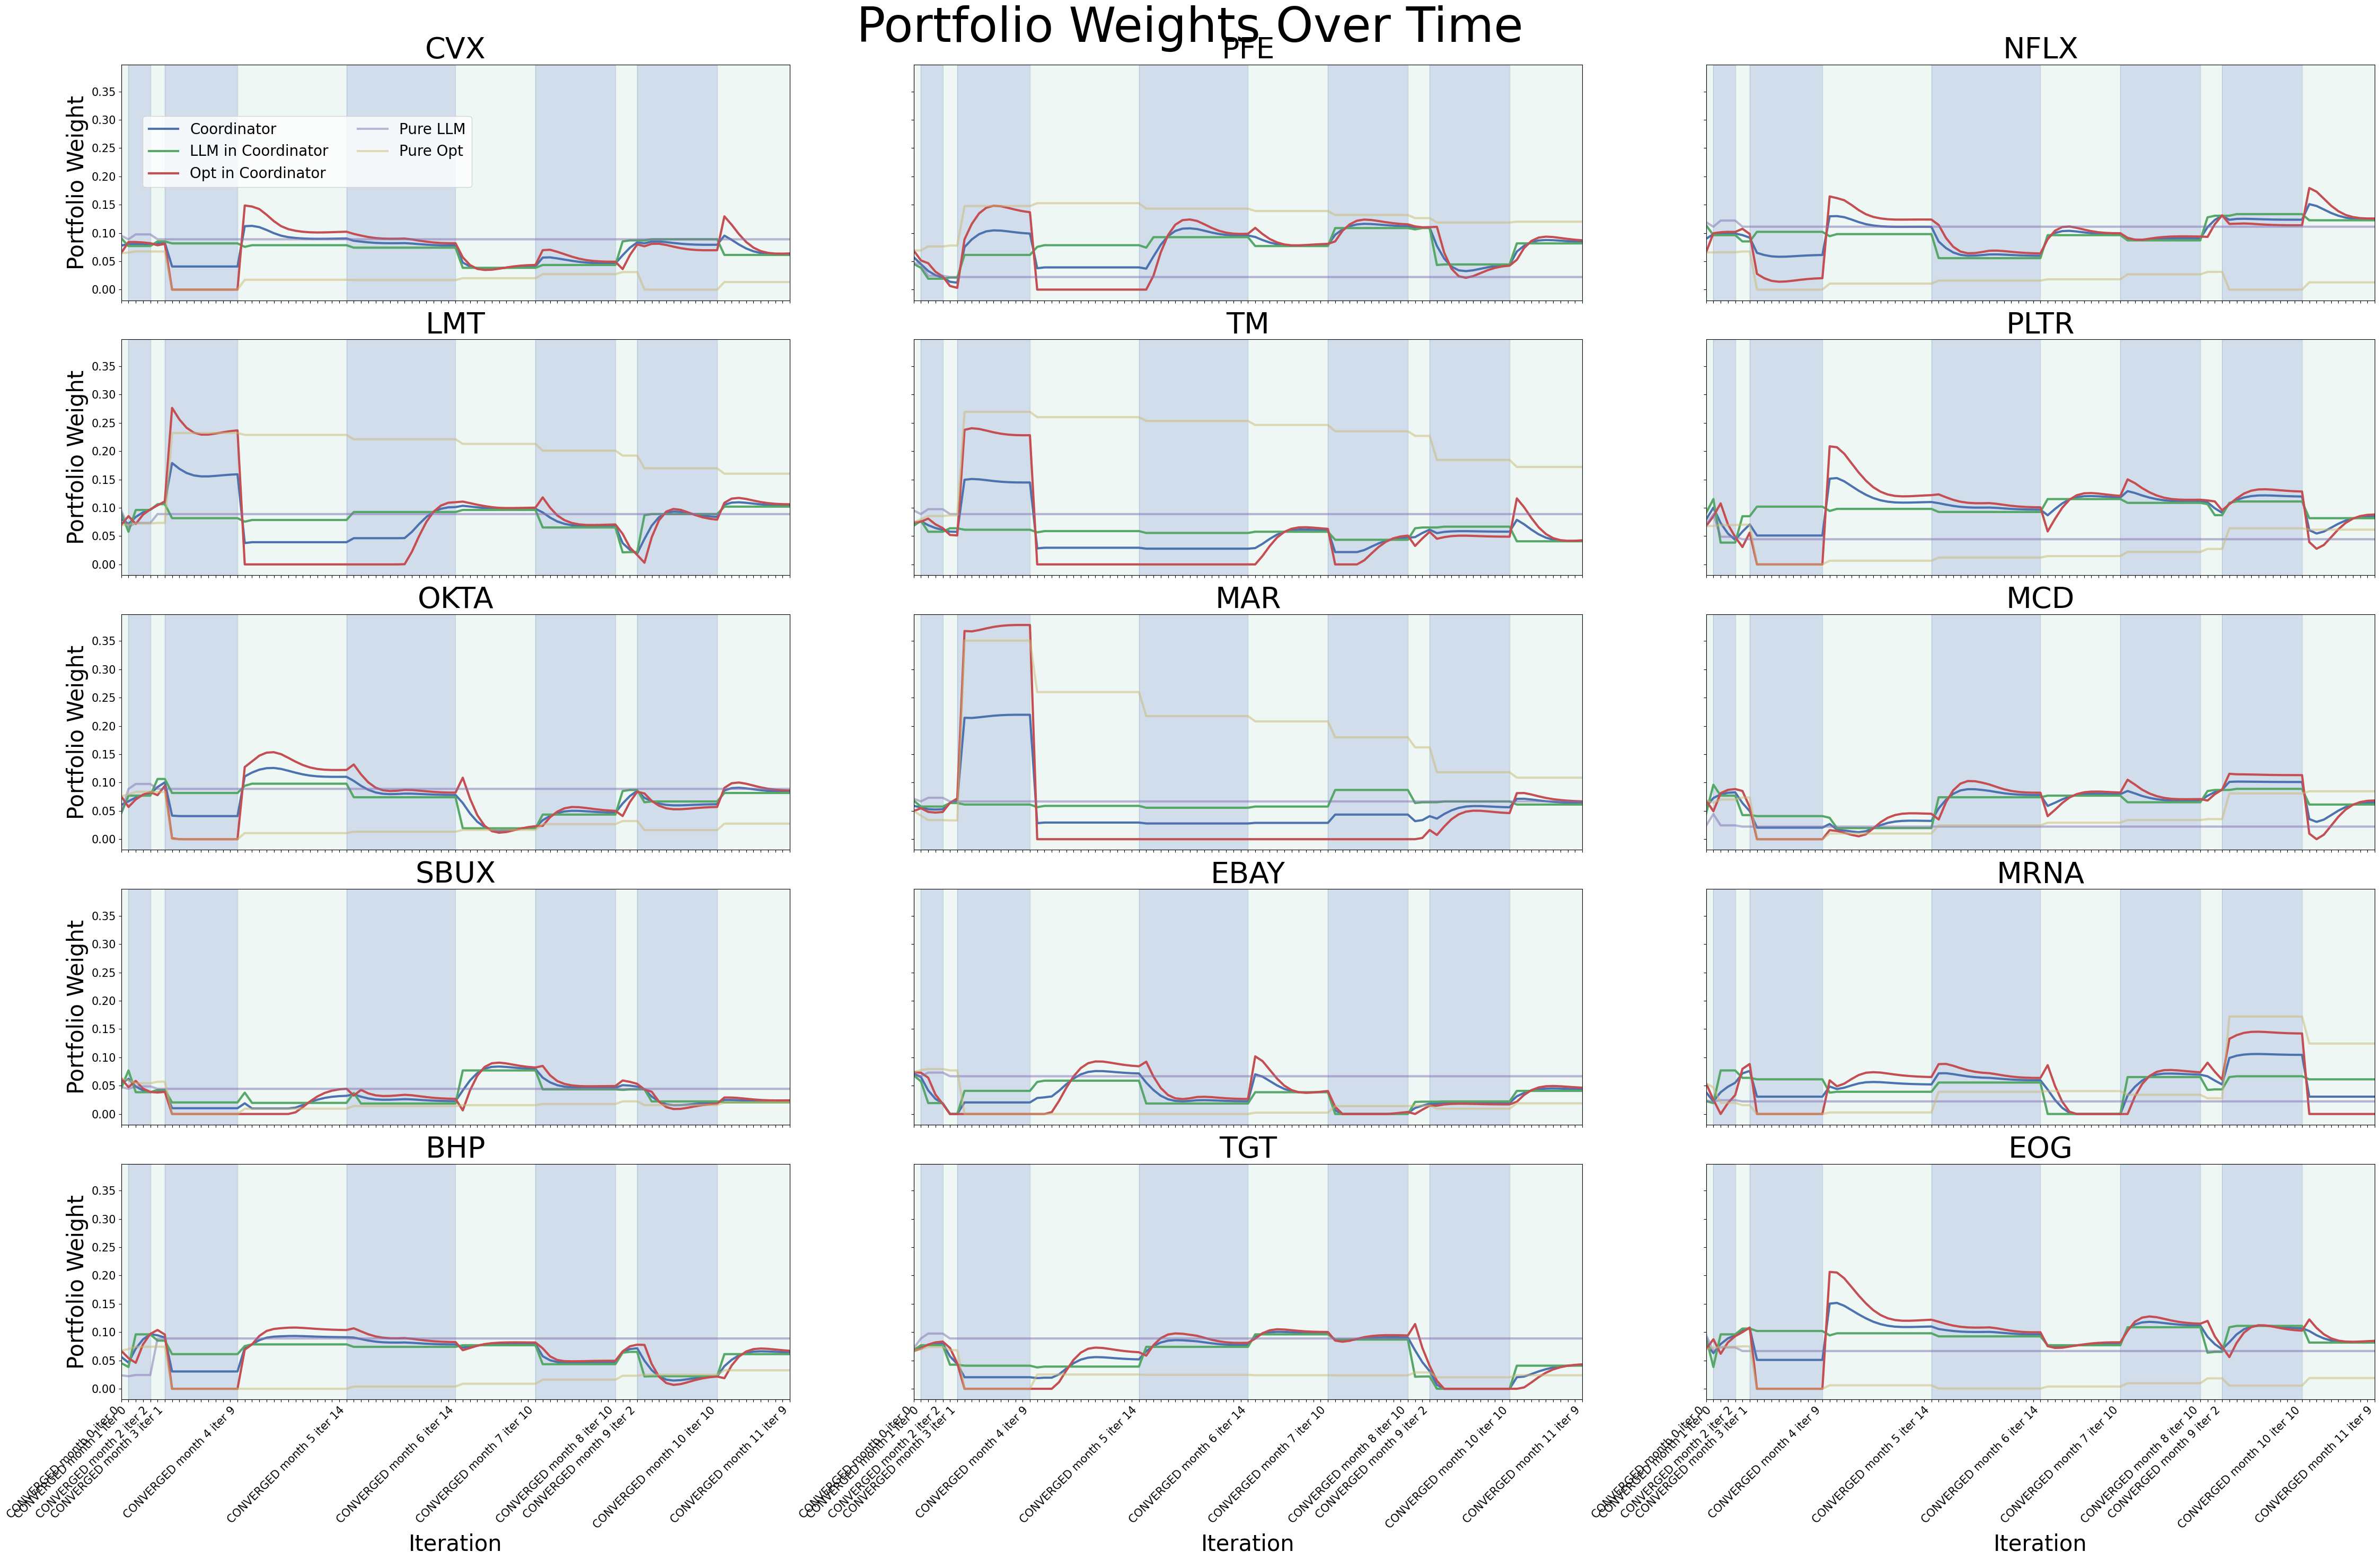

In [50]:
rows = 5
columns = 3

fig, axes = plt.subplots(rows, columns, figsize=(45, 30), sharey=True)
fig.suptitle("Portfolio Weights Over Time", fontsize=65)
plt.subplots_adjust(top=0.6)  

# Flatten the 2D array of axes to make it easier to iterate
axes = axes.flatten()

# Define regions and colors
blue_region = (round(108/255, 2), round(143/255, 2), round(191/255, 2), 0.3)
green_region = (round(201/255, 2), round(230/255, 2), round(219/255, 2), 0.3)

days = []
prev = 0

for i, log in enumerate(df['status']):
    log = log.split()
    j = log.index("month")
    cur = log[j+1]
    if cur != prev:
        days.append(i-1)
        prev = cur

days.append(i+1)

regions = []
for i in range(len(days)-1):
    region_color = blue_region if i % 2 == 0 else green_region
    regions.append((days[i], days[i+1], region_color))

# Generate x-tick labels, hiding those without "CONVERGED"
xtick_labels = []
for status in df['status']:
    if "CONVERGED" in status:
        xtick_labels.append(status)
    else:
        xtick_labels.append("")  # Blank label for non-CONVERGED iterations

for i, ticker in enumerate(tickers):
    
    # Fill regions
    for start, end, color in regions:
        axes[i].axvspan(start, end, color=color, alpha=0.3)

    # Plot lines
    if i == 0:
        axes[i].plot(df['status'], df[f'all {ticker}'], label='Coordinator', linewidth=3)
        axes[i].plot(df['status'], df[f'llm {ticker}'], label='LLM in Coordinator', linewidth=3)
        axes[i].plot(df['status'], df[f'opt {ticker}'], label='Opt in Coordinator', linewidth=3)
        axes[i].plot(df['status'], pure_llm_history[i], label='Pure LLM', linewidth=3, alpha=0.5)
        axes[i].plot(df['status'], pure_opt_history[i], label='Pure Opt', linewidth=3, alpha=0.5)
    else:
        axes[i].plot(df['status'], df[f'all {ticker}'], linewidth=3)
        axes[i].plot(df['status'], df[f'llm {ticker}'], linewidth=3)
        axes[i].plot(df['status'], df[f'opt {ticker}'], linewidth=3)
        axes[i].plot(df['status'], pure_llm_history[i], linewidth=3, alpha=0.5)
        axes[i].plot(df['status'], pure_opt_history[i], linewidth=3, alpha=0.5)
    
    # Title and tick parameters
    axes[i].set_title(f'{ticker}', fontsize=40)
    axes[i].tick_params(axis='x', rotation=45, labelsize=15)
    axes[i].tick_params(axis='y', labelsize=15)

    # Set x-tick labels with filtered labels
    axes[i].set_xticks(range(len(df['status'])))
    axes[i].set_xticklabels(xtick_labels, fontsize=15, rotation=45, ha='right')
    
    # X-axis limit
    axes[i].set_xlim(0, len(df['status']) - 1)
    
    # Y-label on first column
    if i in [i for i in range(0, rows*columns, columns)]:
        axes[i].set_ylabel("Portfolio Weight", fontsize=30)
    
    # X-label only on last row
    if i in [i for i in range(rows*columns-columns, rows*columns)]:
        axes[i].set_xlabel("Iteration", fontsize=30)
    else:
        # Hide x-tick labels for the first two rows
        axes[i].tick_params(axis='x', labelbottom=False)

# Add common legend (adjust location as you like)
fig.legend(loc=(0.06, 0.88), ncol=2, fontsize=20)

plt.tight_layout()

plt.savefig(grid_image_path, dpi=300, bbox_inches='tight')  
plt.show()

#### Backtesting
Seeing how the strategies perform based on historical data

In [51]:
def backtest(df, columns=None, weights_=None):
    i = 0

    initial_capital = 10000
    portfolio_value = initial_capital

    portfolio_history = [portfolio_value]

    while i < 11:
        if columns:
            weights = df.loc[i, columns].tolist()
        else:
            weights = weights_[i]

        # 2. -> buy jan 31
        shares = []
        initial_capital = portfolio_value

        for j, ticker in enumerate(tickers):
            ticker_price = data_loaded[i][ticker]['price']
            shares_bought = initial_capital * weights[j] / ticker_price
            shares.append(shares_bought)
            portfolio_value -= shares_bought * ticker_price
            # print(f"{weights[j] = }\t{ticker_price = } -> {shares_bought = }")

        # 3. -> sell feb 31
        i += 1
        for j, ticker in enumerate(tickers):
            ticker_price = data_loaded[i][ticker]['price']
            portfolio_value += shares[j] * ticker_price

        portfolio_history.append(portfolio_value)

    print(portfolio_value)
    return portfolio_history

df_end = df.iloc[[d - 1 for d in days[1:]]].reset_index(drop=True)
all_weights = ["all " + ticker for ticker in tickers]

# get the beginning price for each month
df_init = df[df['status'].str.contains('iter 0')].reset_index(drop=True)

portfolio_history_coordinated = backtest(df_end, columns=all_weights)
portfolio_history_opt = backtest(df_init, weights_=opt_histories)
portfolio_history_llm = backtest(df_init, weights_=llm_histories)

11685.66413250657
9486.736704177143
10972.801514875993


#### Plot the backtesting

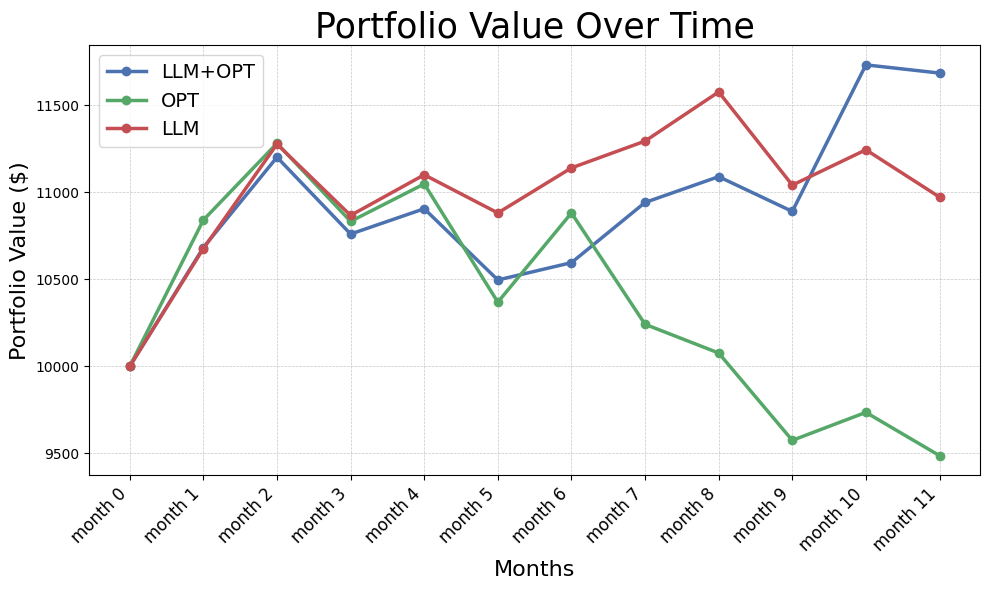

In [52]:
# Create labels for months 0 through 11
months = [f"month {i}" for i in range(12)]

plt.figure(figsize=(10, 6))

# Plot as a line chart with markers
plt.plot(months, portfolio_history_coordinated, linestyle='-', marker='o', linewidth=2.5, label='LLM+OPT')
plt.plot(months, portfolio_history_opt, linestyle='-', marker='o', linewidth=2.5, label='OPT')
plt.plot(months, portfolio_history_llm, linestyle='-', marker='o', linewidth=2.5, label='LLM')

# Add a title, axis labels, and grid
plt.title("Portfolio Value Over Time", fontsize=25)
plt.xlabel("Months", fontsize=16)
plt.ylabel("Portfolio Value ($)", fontsize=16)

# Improve grid styling
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Add a legend with larger font size
plt.legend(fontsize=14, loc='upper left')

# Rotate x-tick labels and align them to the right
plt.xticks(fontsize=12, rotation=45, ha='right')

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.savefig(pft_value_over_time_path, dpi=300, bbox_inches='tight')  
plt.show()